In [1]:
!git clone https://github.com/SteveMama/Differential-ViT.git ViTDiff

Cloning into 'ViTDiff'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 30 (delta 8), reused 27 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 5.65 KiB | 1.88 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
cd ViTDiff

/content/ViTDiff


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
from diff_attn import *
from ViTDiff import *

In [8]:

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_mnist_data(batch_size=64):
    """Load and prepare MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data',
                                 train=True,
                                 download=True,
                                 transform=transform)

    test_dataset = datasets.MNIST(root='./data',
                                train=False,
                                transform=transform)

    train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True)

    test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=False)

    return train_loader, test_loader

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                       desc=f'Epoch {epoch}')

    for batch_idx, (data, target) in progress_bar:
        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()


        outputs = model(data)
        loss = criterion(outputs, target)


        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()


        progress_bar.set_postfix({
            'loss': running_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })

    return running_loss/len(train_loader), 100.*correct/total

def evaluate(model, test_loader, criterion):
    """Evaluate the model"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            test_loss += criterion(outputs, target).item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return test_loss/len(test_loader), 100.*correct/total

In [10]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    """Complete training pipeline"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_acc = 0

    for epoch in range(num_epochs):

        train_loss, train_acc = train_epoch(model, train_loader, criterion,
                                          optimizer, epoch)


        val_loss, val_acc = evaluate(model, test_loader, criterion)


        scheduler.step()


        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')


        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return history

In [11]:
def predict(model, image):
    """Make prediction for a single image"""
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, predicted = output.max(1)
        return predicted.item()

def visualize_predictions(model, test_loader, num_images=10):
    """Visualize predictions on sample images"""
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    fig = plt.figure(figsize=(15, 3))
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i + 1)
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i]}\nTrue: {labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 50.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.79MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.86MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




Epoch 0: 100%|██████████| 938/938 [00:39<00:00, 23.46it/s, loss=0.355, acc=88.9]



Epoch 1/10:
Train Loss: 0.3546, Train Acc: 88.89%
Val Loss: 0.1202, Val Acc: 96.27%


Epoch 1: 100%|██████████| 938/938 [00:38<00:00, 24.43it/s, loss=0.128, acc=96.1]



Epoch 2/10:
Train Loss: 0.1276, Train Acc: 96.09%
Val Loss: 0.0992, Val Acc: 97.01%


Epoch 2: 100%|██████████| 938/938 [00:38<00:00, 24.48it/s, loss=0.0958, acc=97.1]



Epoch 3/10:
Train Loss: 0.0958, Train Acc: 97.08%
Val Loss: 0.0952, Val Acc: 97.15%


Epoch 3: 100%|██████████| 938/938 [00:38<00:00, 24.66it/s, loss=0.0793, acc=97.5]



Epoch 4/10:
Train Loss: 0.0793, Train Acc: 97.48%
Val Loss: 0.0701, Val Acc: 97.77%


Epoch 4: 100%|██████████| 938/938 [00:38<00:00, 24.50it/s, loss=0.0643, acc=98]



Epoch 5/10:
Train Loss: 0.0643, Train Acc: 97.97%
Val Loss: 0.0578, Val Acc: 98.17%


Epoch 5: 100%|██████████| 938/938 [00:38<00:00, 24.67it/s, loss=0.0513, acc=98.3]



Epoch 6/10:
Train Loss: 0.0513, Train Acc: 98.34%
Val Loss: 0.0615, Val Acc: 98.05%


Epoch 6: 100%|██████████| 938/938 [00:37<00:00, 24.93it/s, loss=0.0404, acc=98.7]



Epoch 7/10:
Train Loss: 0.0404, Train Acc: 98.73%
Val Loss: 0.0535, Val Acc: 98.42%


Epoch 7: 100%|██████████| 938/938 [00:39<00:00, 23.96it/s, loss=0.0298, acc=99.1]



Epoch 8/10:
Train Loss: 0.0298, Train Acc: 99.06%
Val Loss: 0.0480, Val Acc: 98.58%


Epoch 8: 100%|██████████| 938/938 [00:39<00:00, 23.68it/s, loss=0.0232, acc=99.4]



Epoch 9/10:
Train Loss: 0.0232, Train Acc: 99.37%
Val Loss: 0.0462, Val Acc: 98.64%


Epoch 9: 100%|██████████| 938/938 [00:37<00:00, 24.78it/s, loss=0.0187, acc=99.5]



Epoch 10/10:
Train Loss: 0.0187, Train Acc: 99.48%
Val Loss: 0.0453, Val Acc: 98.71%


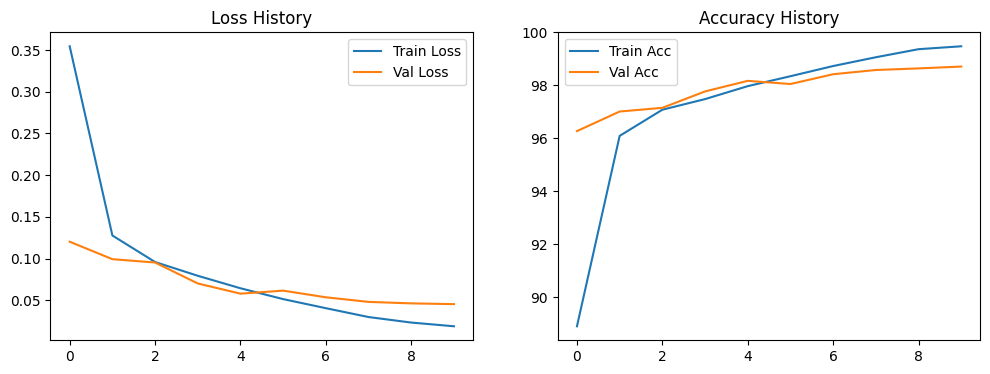

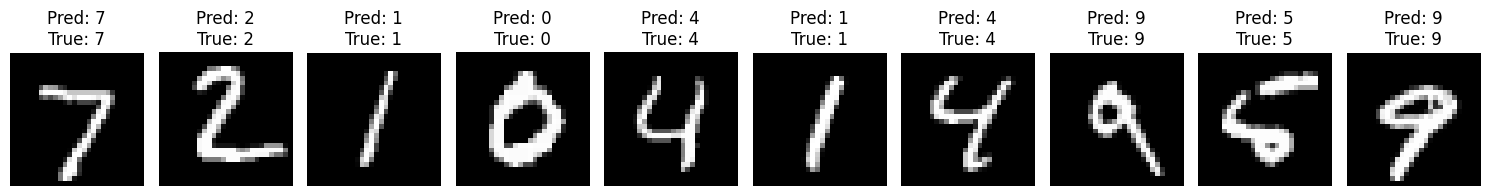

In [12]:
def main():

    train_loader, test_loader = load_mnist_data(batch_size=64)


    model = VisionTransformerDiff(
        image_size=28,
        patch_size=7,
        in_channels=1,
        num_classes=10,
        embed_dim=64,
        depth=6,
        num_heads=8,
        mlp_ratio=4.,
        qkv_bias=False,
        drop_rate=0.1,
        attn_drop_rate=0.1
    ).to(device)


    history = train_model(model, train_loader, test_loader, num_epochs=10)


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss History')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy History')
    plt.show()


    visualize_predictions(model, test_loader)

if __name__ == '__main__':
    main()